#### Import all dependencies

In [256]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from sklearn.utils import resample  # Import resample function for oversampling

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/suonieo1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/suonieo1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Read the data from the file. Rename the columns to "Text" and "Sentiment". Drop the neutral column

In [257]:
df = pd.read_csv('data.csv', delimiter=',', encoding='latin-1', header=None)
df = df.rename(columns=lambda x: ['Sentiment', 'Text'][x])
df = df[['Text', 'Sentiment']]
df = df[df['Sentiment'] != 'neutral']

#### Create the preprocessing function. Here we tokenize the text, remove all punctuations and convert them to lowercase. Then we remove the stopwords and stem the words.
#### Finally we join the words back into a single string and return the processed text.

In [249]:
def preprocess_text(text):
    # Tokenization (split the text into words)
    words = nltk.word_tokenize(text)
    
    # Remove punctuation and convert to lowercase
    words = [word.lower() for word in words if word.isalpha()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stemming (reducing words to their root form)
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(words)
    
    return cleaned_text

#### We apply the preprocessing to each text in the data, so the 'Text' column contains preprocessed text

Columns :  ['Text' 'Sentiment']
Shape of data :  (1967, 2)
                                                    Text Sentiment
count                                               1967      1967
unique                                              1921         2
top     oper profit rose eur mn eur mn correspond period  positive
freq                                                   6      1363

------------------------------ First 10 texts ------------------------------

intern electron industri compani elcoteq laid ten employe tallinn facil contrari earlier layoff compani contract rank offic worker daili postime report
new product plant compani would increas capac meet expect increas demand would improv use raw materi therefor increas product profit
accord compani updat strategi year baswar target net sale growth rang oper profit margin net sale
financ aspocomp growth aspocomp aggress pursu growth strategi increasingli focus technolog demand hdi print circuit board pcb
last quarter compo

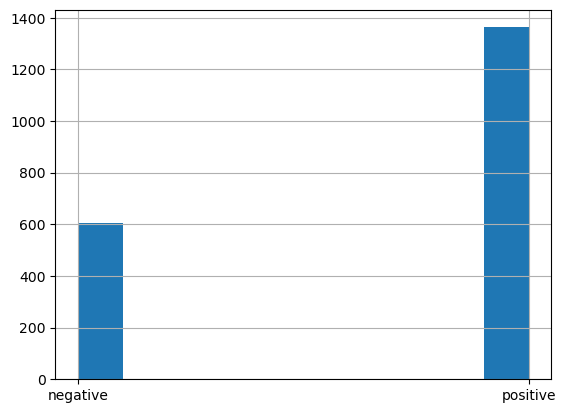

In [250]:
df['Text'] = df['Text'].apply(preprocess_text)

print("Columns : ", df.columns.values)
print("Shape of data : ", df.shape)
print(df.describe())
df["Sentiment"].hist()

print()
print('-'*30, "First 10 texts", '-'*30)
print()
for i, text in enumerate(df['Text']):
    if i < 10:
        print(text)
    else:
        break

#### We split the data into training, validation and test sets.
#### Then we further split the training data into training and validation sets using k-fold cross-validation.
#### We are using method StratifiedKFold over the standard KFold. StratifiedKFold is often preferred over KFold in classification tasks, especially when you have imbalanced class distributions.

In [262]:
X = df['Text']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

# Concatenate the training data back together
X_train = pd.concat([X_train, y_train], axis=1)

# Separate the majority and minority classes
majority_class = X_train[X_train['Sentiment'] == 'positive']
minority_class = X_train[X_train['Sentiment'] == 'negative']

# Upsample the minority class to match the number of majority class samples
minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

# Combine the upsampled minority class with the majority class
X_train_resampled = pd.concat([majority_class, minority_upsampled])

# Separate features and labels
y_train_resampled = X_train_resampled['Sentiment']
X_train_resampled = X_train_resampled.drop('Sentiment', axis=1)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print(y_train_resampled.head())
print(X_train_resampled.head())

932     positive
919     positive
2314    positive
1220    positive
2193    positive
Name: Sentiment, dtype: object
                                                   Text
932   `` We 've been feeling quite positive about th...
919   Wartsila won the contract in October 2007 and ...
2314  The proportion of Estonian and Lithuanian pass...
1220  Finnish automation solutions developer Cencorp...
2193  Tallink claims the watertight doors of both Va...


#### Then we extract features using feature engineering.

#### First we initialize the TfidfVectorizer, Bag of Words (BoW) and Word2Vec vectorizers

In [254]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)  # TF-IDF with 10,000 features
bow_vectorizer = CountVectorizer(max_features=10000)    # BoW with 10,000 features
word2vec_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, sg=0)

#### The we create the lists to store the Tfidf, BoW and the Word2Vec vectors

In [255]:
X_train_tfidf = []
X_val_tfidf = []
X_test_tfidf = []
X_train_bow = []
X_val_bow = []
X_test_bow = []
X_train_w2v = []
X_val_w2v = []
X_test_w2v = []

#### Then we train models for Tfidf, BoW, and Word2Vec vectors

In [168]:
# Then we train and evaluate the models
for train_index, val_index in kfold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Apply Tfidf vectorization
    X_train_tfidf_fold = tfidf_vectorizer.fit_transform(X_train)
    X_val_tfidf_fold = tfidf_vectorizer.transform(X_val)
    X_test_tfidf_fold = tfidf_vectorizer.transform(X_test)

    X_train_tfidf.append(X_train_tfidf_fold)
    X_val_tfidf.append(X_val_tfidf_fold)
    X_test_tfidf.append(X_test_tfidf_fold)

    # Apply BoW vectorization
    X_train_bow_fold = bow_vectorizer.fit_transform(X_train)
    X_val_bow_fold = bow_vectorizer.transform(X_val)
    X_test_bow_fold = bow_vectorizer.transform(X_test)

    X_train_bow.append(X_train_bow_fold)
    X_val_bow.append(X_val_bow_fold)
    X_test_bow.append(X_test_bow_fold)

    # Initialize Word2Vec vectors
    X_train_w2v_fold = []
    X_val_w2v_fold = []
    X_test_w2v_fold = []

    for word in X_train:
        if word in word2vec_model.wv:
            X_train_w2v_fold.append(word2vec_model.wv[word])
        else:
            X_train_w2v_fold.append([0.0] * word2vec_model.vector_size)

    for word in X_val:
        if word in word2vec_model.wv:
            X_val_w2v_fold.append(word2vec_model.wv[word])
        else:
            X_val_w2v_fold.append([0.0] * word2vec_model.vector_size)

    for word in X_test:
        if word in word2vec_model.wv:
            X_test_w2v_fold.append(word2vec_model.wv[word])
        else:
            X_test_w2v_fold.append([0.0] * word2vec_model.vector_size)

    X_train_w2v.append(X_train_w2v_fold)
    X_val_w2v.append(X_val_w2v_fold)
    X_test_w2v.append(X_test_w2v_fold)

In [169]:
X_train_tfidf[0]


<1770x3332 sparse matrix of type '<class 'numpy.float64'>'
	with 19651 stored elements in Compressed Sparse Row format>

In [170]:
for i in range(10):
    # Train and evaluate a model for Tfidf
    lr_model_tfidf = LogisticRegression()
    lr_model_tfidf.fit(X_train_tfidf[i], y_train)
    y_val_pred_lr_tfidf = lr_model_tfidf.predict(X_val_tfidf[i])
    y_test_pred_lr_tfidf = lr_model_tfidf.predict(X_test_tfidf[i])

    # Train and evaluate a model for BoW
    lr_model_bow = LogisticRegression()
    lr_model_bow.fit(X_train_bow[i], y_train)
    y_val_pred_lr_bow = lr_model_bow.predict(X_val_bow[i])
    y_test_pred_lr_bow = lr_model_bow.predict(X_test_bow[i])

    # Train and evaluate a model for Word2Vec
    lr_model_w2v = LogisticRegression()
    lr_model_w2v.fit(X_train_w2v[i], y_train)
    y_val_pred_lr_w2v = lr_model_w2v.predict(X_val_w2v[i])
    y_test_pred_lr_w2v = lr_model_w2v.predict(X_test_w2v[i])

    # Print evaluation metrics for Tfidf, BoW, and Word2Vec
    print(f"Fold {i+1} - Tfidf Validation Results:")
    print("Accuracy:", accuracy_score(y_val, y_val_pred_lr_tfidf))
    print(classification_report(y_val, y_val_pred_lr_tfidf))
    print(f"Fold {i+1} - Tfidf Test Results:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred_lr_tfidf))
    print(classification_report(y_test, y_test_pred_lr_tfidf))

    print(f"Fold {i+1} - BoW Validation Results:")
    print("Accuracy:", accuracy_score(y_val, y_val_pred_lr_bow))
    print(classification_report(y_val, y_val_pred_lr_bow))
    print(f"Fold {i+1} - BoW Test Results:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred_lr_bow))
    print(classification_report(y_test, y_test_pred_lr_bow))

    print(f"Fold {i+1} - Word2Vec Validation Results:")
    print("Accuracy:", accuracy_score(y_val, y_val_pred_lr_w2v))
    print(classification_report(y_val, y_val_pred_lr_w2v))
    print(f"Fold {i+1} - Word2Vec Test Results:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred_lr_w2v))
    print(classification_report(y_test, y_test_pred_lr_w2v))

ValueError: Found input variables with inconsistent numbers of samples: [1770, 1771]